In [1]:
import optuna
import random
import math
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from src.problem_loaders.vrp_loader import VRPLoader
from src.algorithms.ga_vrp import GeneticAltorithmVRP
from src.algorithms.ant_system import AntSystem
from src.algorithms.ant_vrp import AntVRP
from src.plotting import plot_solution

# VRP with GA

In [2]:
PROBLEM_INSTANCE_NAME = 'B-n31-k5'

tsp_loader = VRPLoader(PROBLEM_INSTANCE_NAME)
coordinates, problem_instance, demand, capacity, best_solution, best_solution_cost = tsp_loader.load_problem_instance()
ga_trials = []
def objective(trial):
    params = {
        "mutation_rate" : trial.suggest_float("mutation_rate", 0.01, 0.9),
        "population_size" : trial.suggest_int("population_size", 10,60),
        "elitism_rate" : trial.suggest_float("elitism_rate", 0.01, 0.2)
    }
    ga = GeneticAltorithmVRP(problem_instance, coordinates, demand, capacity, **params)
    ga_trials.append(ga)
    ga.run(trial)

    return np.min(ga.best_fitness_in_generation)

study = optuna.create_study(study_name=f"ga_{PROBLEM_INSTANCE_NAME}", storage=f"sqlite:///ga_{PROBLEM_INSTANCE_NAME}.db", load_if_exists=True, direction="minimize")
study.optimize(objective, n_trials=10)

[I 2022-11-26 16:23:47,394] A new study created in RDB with name: ga_B-n31-k5
Generation: 100%|██████████| 100/100 [02:04<00:00,  1.24s/it]
[I 2022-11-26 16:25:53,023] Trial 0 finished with value: 707.4928567022242 and parameters: {'mutation_rate': 0.5196320040447996, 'population_size': 41, 'elitism_rate': 0.04246775423791463}. Best is trial 0 with value: 707.4928567022242.
Generation: 100%|██████████| 100/100 [00:47<00:00,  2.13it/s]
[I 2022-11-26 16:26:41,004] Trial 1 finished with value: 726.3670392907413 and parameters: {'mutation_rate': 0.714688803688005, 'population_size': 11, 'elitism_rate': 0.05975509474508408}. Best is trial 0 with value: 707.4928567022242.
Generation: 100%|██████████| 100/100 [02:34<00:00,  1.55s/it]
[I 2022-11-26 16:29:17,389] Trial 2 finished with value: 702.3447788182741 and parameters: {'mutation_rate': 0.7151476456668625, 'population_size': 40, 'elitism_rate': 0.07073650434024575}. Best is trial 2 with value: 702.3447788182741.
Generation: 100%|█████████

In [ ]:
for trail, ga in enumerate(ga_trials):
    stats_df = ga.fitness_df()
    chart = sns.lineplot(data=stats_df, x='generation', y='fitness')
    plt.ylim(best_solution_cost * 0.9, stats_df.fitness.max() * 1.1)
    chart.axhline(best_solution_cost, color='red', linestyle='--')
    plt.show()

d:\Code\Python\Uni\Self-Organizing_Systems\exercise_1\src\plotting.py:53: RuntimeWarning: invalid value encountered in divide
  unit_delta_x = delta_x / delta_length
d:\Code\Python\Uni\Self-Organizing_Systems\exercise_1\src\plotting.py:54: RuntimeWarning: invalid value encountered in divide
  unit_delta_y = delta_y / delta_length


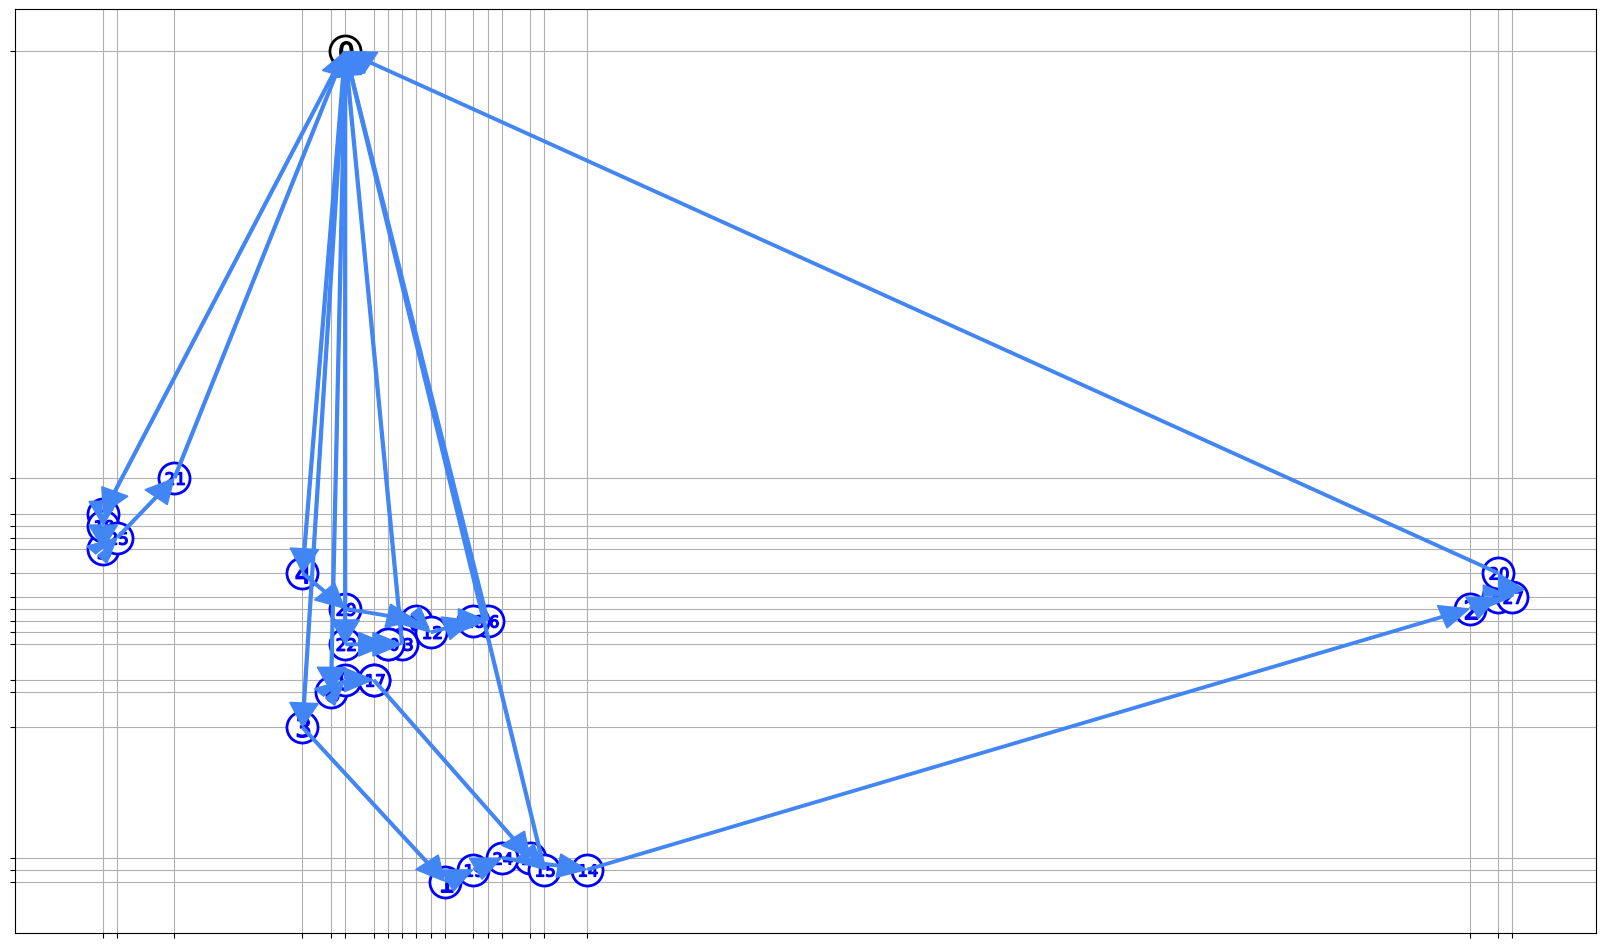

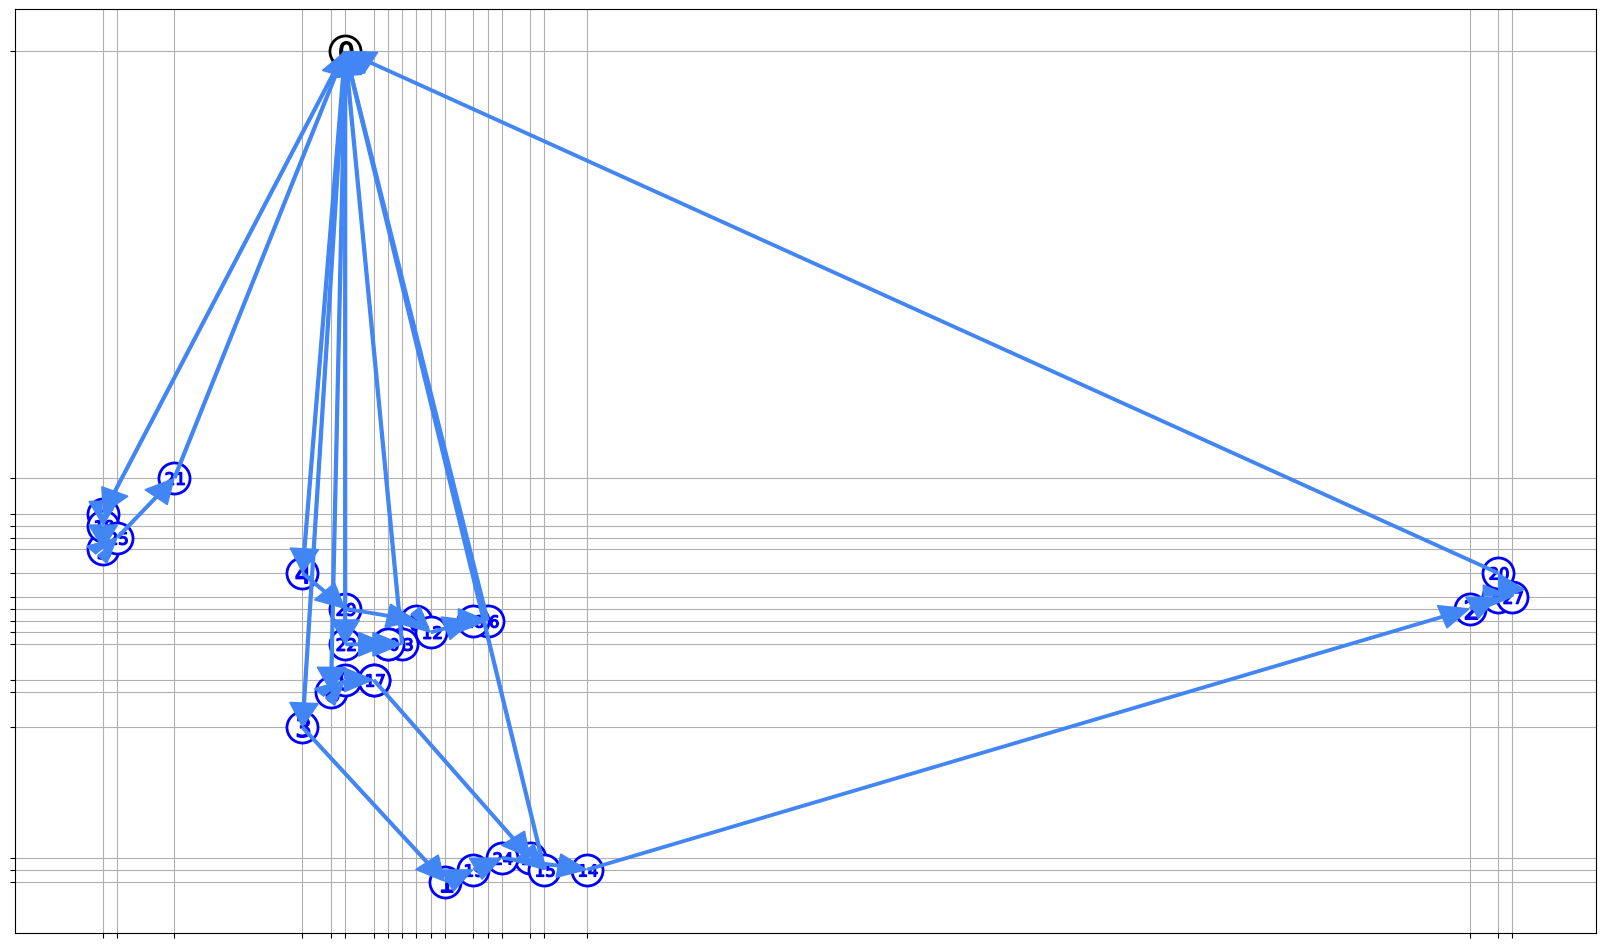

In [ ]:
best_path = ga._get_paths(ga.best_solution.chromosome)[0]
single_path = list(itertools.chain.from_iterable(best_path)) + [0]
fig = plot_solution(coordinates, single_path)

# VRP with Ant System

Time Point: 100%|██████████| 150/150 [01:45<00:00,  1.42it/s]


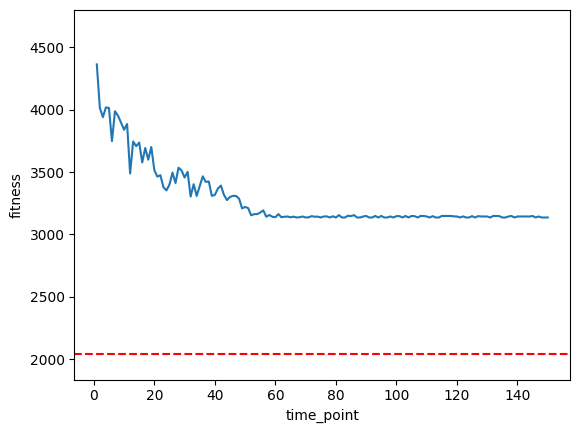

In [4]:
PROBLEM_INSTANCE_NAME = "tai100a"#'X-n655-k131'

vrp_loader = VRPLoader(PROBLEM_INSTANCE_NAME)
coordinates, problem_instance, demand, capacity, best_solution, best_solution_cost = vrp_loader.load_problem_instance()
ant_system = AntSystem(AntVRP, problem_instance, demand=demand, capacity=capacity, debug_mode=False, number_of_ants=75, time=150, visibility="saving_function", trail_update="elitist", alpha=1, beta=4, evaporation_coefficient=0.25, best_rate=0.2, candidate_ratio=0.5)
ant_system.run()
stats_df = ant_system.fitness_df()

chart = sns.lineplot(data=stats_df, x='time_point', y='fitness')
plt.ylim(best_solution_cost * 0.9, stats_df.fitness.max() * 1.1)
chart.axhline(best_solution_cost, color='red', linestyle='--')
plt.show()

In [5]:
ant_system._fitness_all_ants[ant_system._top_ant]

1302.795370918408

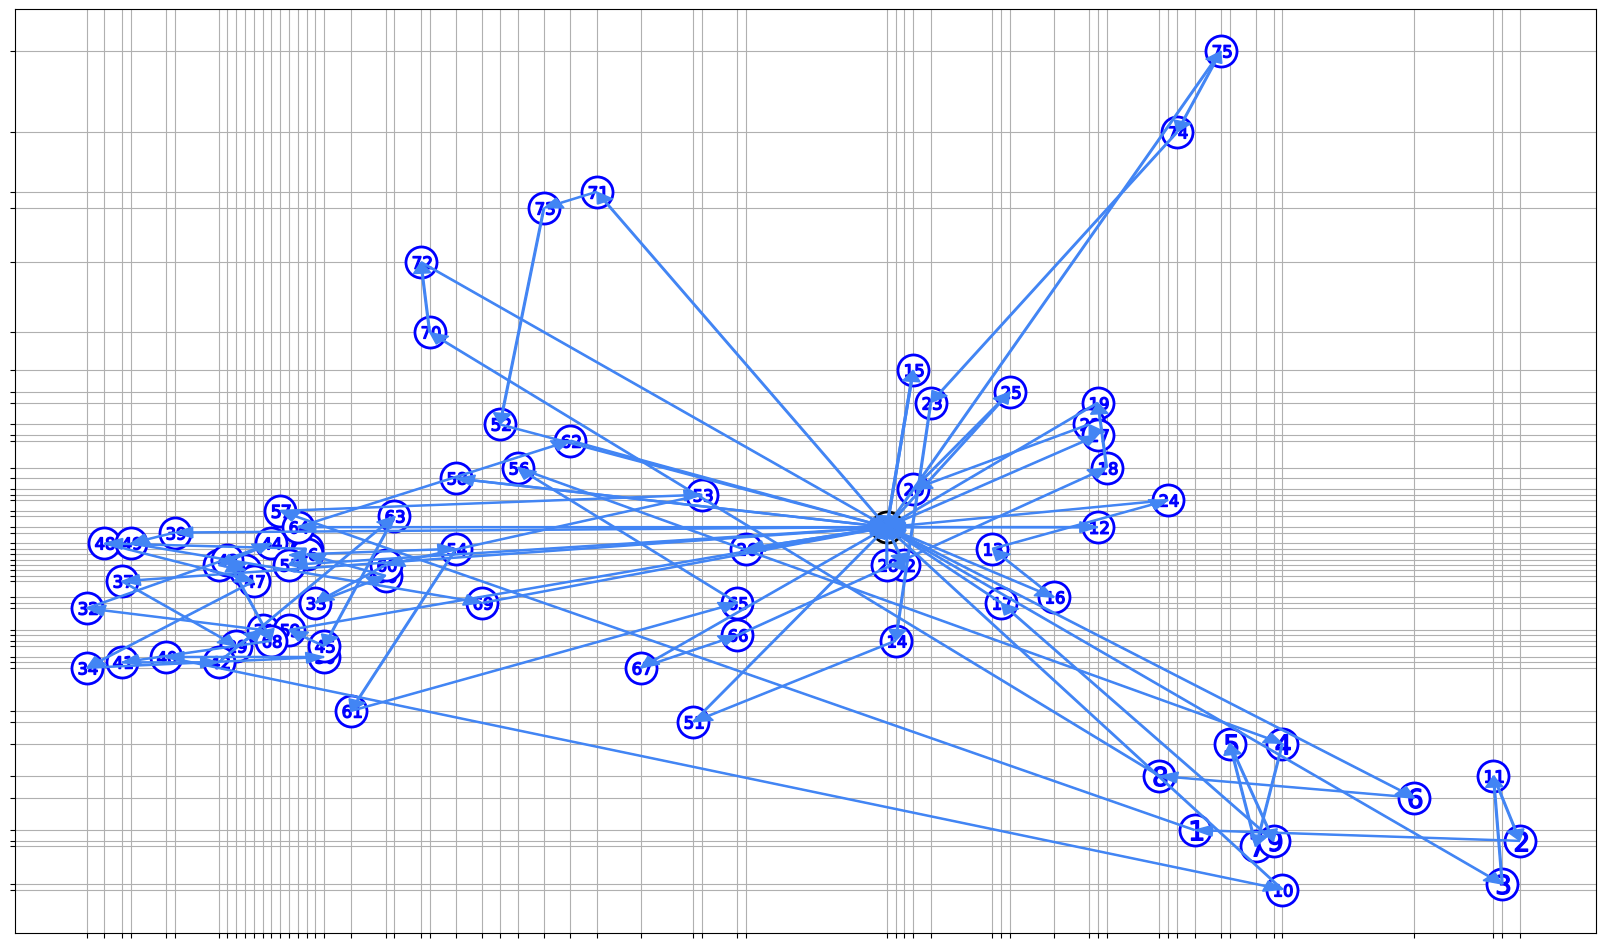

In [3]:
fig = plot_solution(coordinates, ant_system.best_path)